## ML Time Series Analysis 

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing, Holt
from datetime import datetime
import pandas as pd
import pmdarima as pm
from math import sqrt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import model_selection
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Reading data sets
path = "C:/Users/basusag/Documents/Documents/MyPython/CIST Project/Forecasting_w_ST_Mkt_PlatformSub"
file_name = "/SAP-ML-HW_MasterFile_Mkt_PlatSub.xlsm"
#file_name = "/SAP-ML-HPS_HW_MasterFile.xlsm"
#file_name = "/SAP-ML(SKU-Mkt).xlsm"
#sheet="Worksheet1"
#sheet="Accuracy_Check"
sheet = "PL_Mkt"
nrow = 688      # number of rows to read

############################# Parameter Defining #################################
hist_periods = 36
to_fcst = 23
to_skiprows = 3                   # if header, skip

#Volatility % to compress
to_compress = 10

###############################################################################
df = pd.read_excel(path + file_name, 
                   sheet_name = sheet, 
                   #usecols = "H:FP",
                   usecols = "H:BN",
                   #usecols = "H:AT",
                   skiprows = to_skiprows,
                   nrows = nrow)

# Making unique key column
con_cat = df.iloc[:,0].map(str) + '_' + df.iloc[:,1].map(str)
df.insert(loc = 2, column = "Key", value = con_cat)

##########################################################################################################################
def fwd_season(season, fcst): 
    fit_extend = season.tshift(len(out_sample))
    fwd_only = fit_extend.tail(len(out_sample))
    ft = fcst + fwd_only
    return ft

def create_features(xg_df):
    xg_df['Month'] = xg_df.index.month
    xg_df['DaysofMonth'] = xg_df.index.daysinmonth
    xg_df['Quarter'] = xg_df.index.quarter
    xg_df['Year'] = xg_df.index.year
    xg_df['DayOfYear'] = xg_df.index.dayofyear
    xg_df['WeekOfYear'] = xg_df.index.isocalendar().week
    return xg_df 

def data_cleaning(uv_ts):
    
    val = next(index for index,value in enumerate(uv_ts) if value > 0)
    uv_start_val = uv_ts[val: ]
    #uv_start_val = uv_ts.head(hist_periods)
    uv_hist = uv_start_val.copy()
    
    nulls = uv_ts.mask(uv_ts < 1)        
    uv_data = nulls.fillna(value = nulls.mean())
    
    # Seasonal Decomposition
    stl = STL(uv_data, period = 12)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid

    # Anomalies treatment from residual components
    lower_resid = np.percentile(resid, to_compress)          
    upper_resid = np.percentile(resid, (100 - to_compress))

    resid = resid.copy()
    resid[resid < lower_resid] = lower_resid
    resid[resid > upper_resid] = upper_resid

    # From Seasonal components 
    lower_season = np.percentile(seasonal, to_compress)          
    upper_season = np.percentile(seasonal, (100 - to_compress)) 

    season = seasonal.copy()
    season[season < lower_season] = lower_season
    season[season > upper_season] = upper_season

    # Combining Cleaned components
    season = season.groupby(season.index.month).transform('mean')
    trend_season_resid = trend + season + resid
    
    tsr = trend_season_resid.mask(trend_season_resid < 1)
    tsr = tsr.bfill()
    tsr = tsr.ffill()
    
    tes_data = pd.Series(data = tsr, index = pd.DatetimeIndex(tsr.index, freq ='MS'))
    
    
    season_resid = season + resid
    sr = season_resid.mask(season_resid < 1)
    sr = sr.bfill()
    sr = sr.ffill()
    
    sr_data = pd.Series(data = sr, index = pd.DatetimeIndex(sr.index, freq ='MS'))
    
    
    return(tes_data)


params = {
    "bootstrap"         : [True, False],
    "criterion"         : ['mse', 'mae'],
    "learning_rate"     : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"         : [2, 5, 8, 11, 14, 17, 20],
    "min_child_weight"  : [2, 4, 6, 8],
    "gamma"             : [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree"  : [0.3, 0.5, 0.7, 0.9],
    "colsample_bylevel" : [0.3, 0.5, 0.7, 0.9],
    "n_estimators"      : [50, 100, 200, 300, 500]    
}


def grid_cv(x):
    param_grid={
        'bootstrap'         : [x.best_params_['bootstrap']],
        "criterion"         : [x.best_params_['criterion']],
        "learning_rate"     : [x.best_params_['learning_rate']],
        "max_depth"         : [x.best_params_['max_depth']-1,
                               x.best_params_['max_depth'],
                               x.best_params_['max_depth']+1],
        "min_child_weight"  : [x.best_params_[ "min_child_weight"]-1, 
                               x.best_params_[ "min_child_weight"],
                               x.best_params_[ "min_child_weight"]+1],
        "gamma"             : [x.best_params_[ "gamma"]],
        "colsample_bytree"  : [x.best_params_[ "colsample_bytree"]-0.1, 
                               x.best_params_[ "colsample_bytree"],
                               x.best_params_[ "colsample_bytree"]+0.1],
        "colsample_bylevel" : [x.best_params_[ "colsample_bylevel"]-0.1, 
                               x.best_params_[ "colsample_bylevel"],
                               x.best_params_[ "colsample_bylevel"]+0.1],
        "n_estimators"      : [x.best_params_[ "n_estimators"]-30,
                               x.best_params_[ "n_estimators"],
                               x.best_params_[ "n_estimators"]+30]
        }
    
    return(param_grid)


############################################### Sell-Thru Forecasting ####################################################
############################################################################################################################

key_dim = df.iloc[:,2].unique()

key_list = 0
df_list = []

for i in key_dim: 
    
    key_list = df[df.iloc[:,2]==i] 
    key_list = key_list.iloc[:,3:]
    key_list = key_list.set_index(key_list.iloc[:,0])
    key_list = key_list.iloc[:, 1:].T
    key_list.columns = key_list.columns.str.replace(' ','_')
    key_list = key_list.set_index(pd.to_datetime(key_list.index, format = '%y-%b'))


    uv_ts = key_list['Ship-Actl_PGI'].head(hist_periods)
    val = next(index for index,value in enumerate(uv_ts) if value > 0)
    uv_start_val = uv_ts[val: ]
    
    nulls = uv_ts.mask(uv_ts < 1)        
    uv_data = nulls.fillna(value = 1)

    # Model selection criteria
    Yr_Avg = uv_ts.fillna(value = 0).resample('12ME', origin = 'start', closed = 'left').mean()
    avg_st = nulls.tail(6).sum()/6
    count_6 = nulls.tail(6).count()
    count = uv_start_val.count()
    cols = key_list.columns
    
    
    if (uv_ts.tail(12).sum()==0):                #Exclude if no shipmet in 12 months
        continue 
        
    out_sample = pd.date_range(start= max(uv_ts.index), periods= to_fcst, freq = '1ME') + pd.offsets.MonthBegin(1)
        
    ############################################### ST Seasonal component Forecast ###########################################  

    if key_list["ST"].sum()>0:
        corrected_st = data_cleaning(key_list["ST"].head(hist_periods))
    else:
        corrected_st = key_list["ST"].head(hist_periods)
    #corrected_st = key_list["ST"].head(hist_periods)
    #corrected_st = corrected_st.fillna(value = corrected_st.mean())
    
    corrected_ship = data_cleaning(key_list["Ship-Actl_PGI"].head(hist_periods))
    #corrected_ship = key_list['Ship-Actl_PGI'].head(hist_periods)
    #corrected_ship = corrected_ship.fillna(value = corrected_ship.mean())
    
    
    FEATURES = ['MS','Lag1MS', 'Lag2MS', 'Lag3MS','Month', 'DaysofMonth', 'Quarter', 'Year', 'DayOfYear', 'WeekOfYear']
    TARGET = "ST"

    kf = KFold(n_splits=10, shuffle=False)
    regressor = xgb.XGBRegressor()
        
    model = model_selection.RandomizedSearchCV(estimator = regressor, param_distributions= params, random_state=42,
                                               n_iter=5, scoring= 'neg_mean_absolute_error', n_jobs= -1, cv=kf)
    
    xgb_ms = key_list[['MS']]
    xgb_ms['Lag1MS'] = xgb_ms['MS'].shift(-1)
    xgb_ms['Lag2MS'] = xgb_ms['MS'].shift(-2)
    xgb_ms['Lag3MS'] = xgb_ms['MS'].shift(-3)
    
    xgb_ms = xgb_ms.fillna(value = xgb_ms.mean())

    xgb_h = pd.concat([corrected_st, xgb_ms], axis=1)
    xgb_h.columns = ["ST", "MS", 'Lag1MS', 'Lag2MS', 'Lag3MS']
      

########################### Sell-Thru forecasting Using MS and its lags ###############################


    if (Yr_Avg[2] > Yr_Avg[1] and Yr_Avg[2] > Yr_Avg[0]) or xgb_ms['MS'].sum()==0:
    #if xgb_ms['MS'].sum()>0 :
        
        
        st_drivers = xgb_h[["MS", 'Lag1MS', 'Lag2MS', 'Lag3MS']]

        sxmodel = pm.auto_arima(corrected_st, 
                        exogenous=st_drivers.head(hist_periods),
                        start_p=0, start_q=0,
                        test='adf',
                        max_p=1, max_q=1, 
                        m=12,
                        d=0, D=0, 
                        trace=False,
                        seasonal=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)


        output = sxmodel.predict(n_periods=to_fcst,
                                 exogenous=st_drivers.tail(to_fcst))



        tes_model = ExponentialSmoothing(corrected_st, 
                                         trend = "add", 
                                         seasonal = "add", 
                                         seasonal_periods = 12,
                                         damped_trend = True,
                                         initialization_method='estimated').fit()

        tes_output = tes_model.forecast(len(out_sample))

        combo_fcst = pd.Series((output+tes_output)/2, index=out_sample)

        print("Classical fcst for ST :" + i)


    
    else:

        xgb_hist = create_features(xgb_h)
        xgb_f = xgb_hist.head(hist_periods)

        x_all = xgb_f[FEATURES]
        y_all = xgb_f[TARGET]

        model_randCV = model.fit(x_all, y_all)
        param_grid = grid_cv(model_randCV)
        grid_search=GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

        best_algo = grid_search.fit(x_all, y_all)
        xgb_out_s = xgb_hist.tail(to_fcst)
        xgb_fcst = xgb_out_s[FEATURES]
        xgb_output = best_algo.predict(xgb_fcst)
        
        combo_fcst = pd.Series(xgb_output,index=out_sample)
        
        print("XGBoost Fcst for ST:" + i)
    
    
##################################### Shipment Forecast #######################################    


        ST_w_Fcst = pd.concat([corrected_st, combo_fcst], axis=0) 

        frames = [corrected_ship, xgb_ms, ST_w_Fcst]
        new_df = pd.concat(frames, axis=1)
        new_df.columns = ['Ship-Actl_PGI', 'MS', 'Lag1MS', 'Lag2MS', 'Lag3MS', 'ST'] 

        new_df['lag1ST'] = new_df['ST'].shift(-1)
        new_df['lag2ST'] = new_df['ST'].shift(-2)
        new_df['lag3ST'] = new_df['ST'].shift(-3)

        new_df = new_df.ffill()


    if (Yr_Avg[2] > Yr_Avg[1] and Yr_Avg[2] > Yr_Avg[0]) or xgb_ms['MS'].sum()==0 or corrected_st.sum()==0:

        

            shipment_drivers = new_df[["ST", 'lag1ST', 'lag2ST', 'lag3ST', 'MS']]
            
            sxmodel = pm.auto_arima(corrected_ship, 
                            exogenous=shipment_drivers.head(hist_periods),
                            start_p=0, start_q=0,
                            test='adf',
                            max_p=1, max_q=1, 
                            m=12,
                            d=0, D=0, 
                            trace=False,
                            seasonal=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=False)


            ship_output = sxmodel.predict(n_periods=to_fcst,
                                     exogenous=shipment_drivers.tail(to_fcst))
            


            tes_model = ExponentialSmoothing(corrected_ship, 
                                             trend = "add", 
                                             seasonal = "add", 
                                             seasonal_periods = 12,
                                             damped_trend = True,
                                             initialization_method='estimated').fit()

            tes_output = tes_model.forecast(len(out_sample))
            
            ship_fcst = pd.Series((ship_output+tes_output)/2, index=out_sample)
            
            print("Classical fcst for Shipment: " + i)
        
        
    else:


        FEATURES1 = ['ST', 'lag1ST', 'lag2ST', 'lag3ST', 'Month', 'DaysofMonth', 'Quarter',
                     'DayOfYear', 'WeekOfYear', 'MS', 'Lag1MS', 'Lag2MS', 'Lag3MS']
        TARGET1 = "Ship-Actl_PGI"

        actl_df = create_features(new_df)
        actl_hist = actl_df.head(hist_periods)
        actl_hist = actl_hist.fillna(value=1)

        x_all1 = actl_hist.head(hist_periods)[FEATURES1]
        y_all1 = actl_hist.head(hist_periods)[TARGET1]

        model_randCV1 = model.fit(x_all1, y_all1)
        param_grid = grid_cv(model_randCV1)
        grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, cv=5, n_jobs=-1, verbose=2)

        best_algo1 = grid_search.fit(x_all1, y_all1)

        actl_f = actl_df.tail(to_fcst)
        actl_fcst = actl_f[FEATURES1]
        actl_fcst = actl_fcst.ffill()
        
        ship_fcst = pd.Series(best_algo1.predict(actl_fcst), index=actl_fcst.index)

        
        print('XGBoost Fcst for Shipment:' + i)
    
    
########################################Dataframes for exporting the forecast########################################
    
    
    fit_df = pd.DataFrame(ship_fcst, index = out_sample)

    masked = fit_df.mask(fit_df < 0)
    masked_df = masked.ffill()
    masked_df = np.ceil(masked_df.bfill())
    
    
    for_plting = masked_df.copy()
    for_plting = pd.concat([for_plting, combo_fcst], axis = 1)
    for_plting.columns = ["ShipFcst w ST", "Sell-Thru Fcst"]

    masked_df.index = masked_df.index.strftime('%y-%b')
    data_set = masked_df.T
    data_set.insert(loc = 0, column = "Dim-2", value = i)
    data_set.insert(loc = 1, column = "Key Figure", value = ["ShipFcst w ST"])
    df_list.append(data_set)

    #print(mean_absolute_percentage_error(key_list['Ship-Actl_PGI'].head(hist_periods+(36-hist_periods)).tail(3), fit_df.head(3)))
    
    
printables = pd.concat(df_list, axis = 0)
printables[['Dim-2', 'Dim-1']] = printables['Dim-2'].str.split('_', expand=True)
printables.insert(1, 'Dim-1', printables.pop("Dim-1"))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for ST:2N_LATIN AMERICA
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for Shipment:2N_LATIN AMERICA
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for ST:2N_NORTH AMERICA
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for Shipment:2N_NORTH AMERICA
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for ST:4L_LATIN AMERICA
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for Shipment:4L_LATIN AMERICA
Classical fcst for ST :4L_NORTH AMERICA
Classical fcst for Shipment: 4L_NORTH AMERICA
Classical fcst for ST :4X_LATIN AMERICA
Classical fcst for Shipment: 4X_LATIN AMERICA
Classical fcst for ST :4X_NORTH AMERICA
Classical fcst for Shipment: 4X_NORTH AMERICA
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Fcst for ST:5M_NORTH AMERICA
Fitting 5 folds f

In [8]:
printables.to_csv(path + "/ML_OutPut/PL_Mkt-10%Compression_OPS&HPS.csv", index = False)

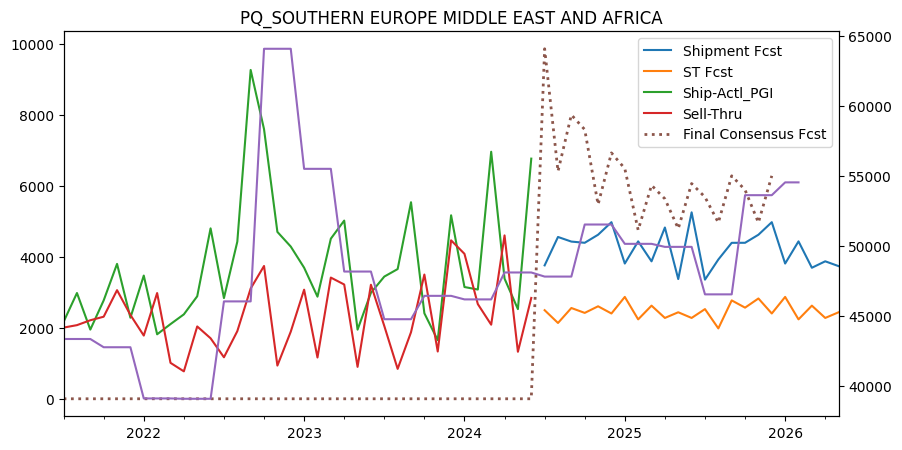

In [7]:
ax = for_plting.plot(figsize=(10,5))

key_list['Ship-Actl_PGI'].head(36).plot()
key_list['ST'].head(36).plot()

key_list['MS'].plot(secondary_y = True, ax=ax)
key_list['Final_Consensus_Fcst'].plot(linestyle = 'dotted', linewidth = 2)
ax.legend(['Shipment Fcst', 'ST Fcst', 'Ship-Actl_PGI', 'Sell-Thru', 'Final Consensus Fcst'])
plt.title(i)
plt.show()

In [4]:
Yr_Avg

2022-05-31    56011.250000
2023-05-31    32557.833333
2024-05-31    40573.166667
Freq: 12ME, Name: Ship-Actl_PGI, dtype: float64

In [ ]:
all_data = pd.DataFrame(data_cleaning(key_list['ST']))
all_data.columns = ['ST']
all_data = create_features(all_data)

random_search = model_selection.RandomizedSearchCV(estimator = regressor, param_distributions= params, random_state=1, 
                                                   return_train_score=True, n_iter=5, scoring= 'accuracy', 
                                                   n_jobs= -1, cv=5, verbose=10)

FEATURES1 = ['Month', 'DaysofMonth', 'Quarter', 'Year', 'DayOfYear', 'WeekOfYear', 'MS']
TARGET1 = ['ST']

tes_model = ExponentialSmoothing(key_list['Ship-Actl_PGI'].head(36).fillna(value=0),
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 12,
                                 damped_trend = True,
                                 initialization_method='estimated').fit()

Forecast for future periods
n_periods = len(key_list[['ST']].tail(23))
output = output = tes_model.forecast(23)

sarimax = pd.Series(output, index=key_list[['MS']].tail(23).index)


x_test_1yr = all_data.tail(12)[FEATURES1]
y_test_1yr = all_data.tail(12)[TARGET1]

x_all = all_data[FEATURES1]
y_all = all_data[TARGET1]

best_algo2 = random_search.fit(x_all, y_all)

grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=3)
best_algo2 = grid_search.fit(x_all, y_all)

xg_out_all = create_features(pd.DataFrame(out_sample, index=out_sample))
xg_fcst_all = xg_out_all[FEATURES1]
xg_fcst_all['Fcst_out_all'] = best_algo2.predict(xg_fcst_all)

ax = key_list['Ship-Actl_PGI'].head(36).plot(figsize=(10,5))
ST_w_Fcst.plot(ax=ax)
combo_fcst.plot(ax=ax)
key_list['MS'].plot(secondary_y = True, ax=ax, linewidth = 0.7)
#sarimax.plot()
ax.legend(['Sell-Thru', 'XGB without MS', 'XGB+MS', 'Classical'])
plt.title(i)
plt.show()

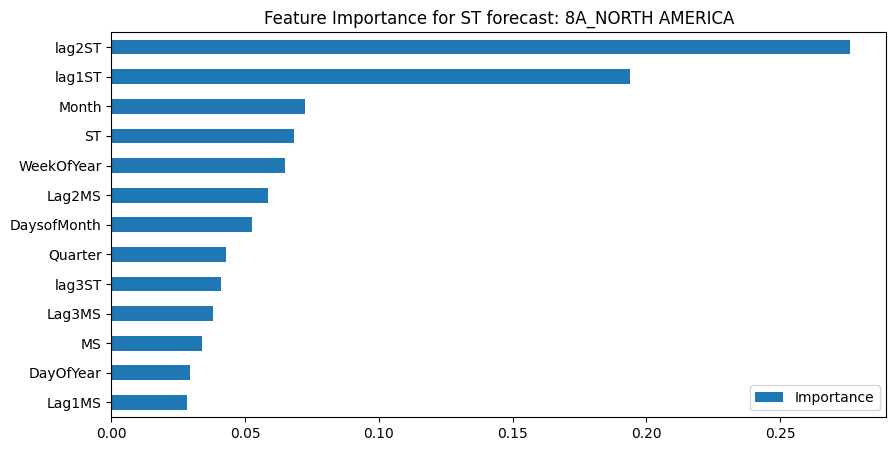

In [24]:
fi = pd.DataFrame(data = best_algo1.best_estimator_.feature_importances_,
             index = best_algo1.best_estimator_.feature_names_in_,
             columns=['Importance'])
fi.sort_values('Importance').plot(kind="barh", title = "Feature Importance for ST forecast: "+i, figsize = (10,5))
plt.show()

In [ ]:
ax = for_plting.plot(figsize=(10,5))
key_list['Ship-Actl_PGI'].head(36).plot()
#test = pd.Series(best_algo1.predict(x_test1), index=x_test1.index)
#corrected_ship.plot(linestyle = 'dashed')
ST_w_Fcst.plot(linestyle = 'dotted')
#key_list['MS'].plot(secondary_y = True, ax=ax)
key_list['Final_Consensus_Fcst'].plot(linewidth = 0.8)
#sarimax.plot()
#ax.legend([ 'Shipment Fcst','Univariate Fcst', 'Test_set Fcst', 'Ship-Actl_PGI', 'CorrectedShip', 'ST'])
plt.title(i)
plt.show()

In [ ]:
fi = pd.DataFrame(data = best_algo1.best_estimator_.feature_importances_,
             index = best_algo1.best_estimator_.feature_names_in_,
             columns=['Importance'])
fi.sort_values('Importance').plot(kind="barh", title = "Feature Importance for Shipment forecast: "+i, figsize = (10,5))
plt.show()

In [ ]:
#pd.concat(xgb_h, axis=1)
fi.sort_values('Importance', ascending=False).index

In [ ]:
key_list['Ship-Actl_PGI'].head(36).fillna(value=0)

In [ ]:
# After Grid_search(ST)
best_algo.best_params_

In [ ]:
# After Grid_search(Shipment)
best_algo1.best_params_

In [ ]:
#Random Search Model (ST), Random State = 1
model.best_params_

In [ ]:
#Random Search Model (Shipment), Random State = 42
model1.best_params_

In [ ]:
st = key_list['ST'].head(36).fillna(value = 1)
sxmodel = pm.auto_arima(st,
                        exogenous=new_data[['MS']].head(36),
                        start_p=0, start_q=0,
                        test='adf',
                        max_p=1, max_q=1, 
                        m=12,
                        d=0, D=0, 
                        trace=False,
                        seasonal=False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)

# Forecast for future periods
n_periods = len(key_list[['ST']].tail(23))
output = sxmodel.predict(n_periods=n_periods,
                         exogenous=new_data[['MS']].tail(23))

sarimax = pd.Series(output, index=key_list[['MS']].tail(23).index)

In [ ]:
sxmodel.summary()

In [ ]:
len(st_cleaned)

# Train the model with all dataset

In [ ]:
    FEATURES = ['MS', 'Lag1MS', 'Lag2MS', 'Month', 'DaysofMonth', 'WeekOfYear']
    TARGET = "ST"
    FEATURES1 = ['ST', 'lag1ST', 'lag2ST', 'lag3ST', 'MS', 'Month']
    TARGET1 = "Ship-Actl_PGI"
    
    compression 1%
    Both XGBoost
    
FEATURES1 = ['ST', 'lag2ST', 'MS', 'Month']
FEATURES = ['MS', 'Lag1MS', 'Lag2MS', 'Month', 'DaysofMonth', 'WeekOfYear']
    